# Notebook to infer the distribution of 3D shapes of the galaxies from the distribution of their 2D shapes


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table
from astropy import units as u


from scipy.spatial.transform import Rotation

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform

from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

import pandas as pd

from astropy.io import fits

import corner

import jaxili

import seaborn as sns

### Downloading the Abacus halos (z=0.575)

In [2]:
halos_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_halos_z0.575_all_mass.fits')

nb_halos = 25_000

random_indices = np.random.choice(len(halos_table), size=nb_halos, replace=False)
halos_table = halos_table[random_indices]


# Positions in 3D
x = halos_table['x_L2com'][:,0] * u.Mpc
y = halos_table['x_L2com'][:,1] * u.Mpc
z = halos_table['x_L2com'][:,2] * u.Mpc

x_val = x.value ; y_val = y.value ; z_val = z.value

In [65]:
halos_table

x_L2com,sigman_L2com,sigman_eigenvecsMin_L2com,sigman_eigenvecsMid_L2com,sigman_eigenvecsMaj_L2com,N
float32[3],float32[3],float32[3],float32[3],float32[3],uint32
-146.43828 .. -204.47308,1253.875 .. 965.3125,-0.83859193 .. 0.42657846,-0.03501521 .. -0.6628713,0.5436336 .. 0.6153312,137
582.8691 .. -648.5614,1218.125 .. 1056.5,0.12825221 .. 0.239924,0.21551424 .. 0.940366,0.96804184 .. -0.24113943,386
356.8961 .. 772.5468,1333.0625 .. 967.375,0.39167255 .. 0.84055746,-0.42143324 .. 0.5254508,0.81791604 .. -0.13177495,937
-646.5291 .. -659.9291,1328.9375 .. 1008.9375,0.73014694 .. 0.612666,-0.41081244 .. 0.7474095,-0.5460023 .. 0.25694227,423
-128.19162 .. -835.154,1297.25 .. 990.5,-0.13856159 .. 0.093640365,0.98792505 .. 0.08274766,-0.06931687 .. 0.99216145,57
-95.2338 .. 338.4672,1583.875 .. 732.75,0.27650172 .. 0.9237854,-0.5306515 .. -0.083041936,0.80122143 .. -0.3737975,37
126.93274 .. 587.8676,1318.375 .. 1027.3125,0.034896005 .. 0.9992909,-0.9261195 .. 0.03765309,0.37561277 .. 0.0,115
-327.69775 .. 339.60507,1336.25 .. 935.0,0.7857259 .. -0.110426575,0.006311372 .. 0.98531663,0.6185427 .. 0.1302195,37
-994.8882 .. -534.5723,1426.625 .. 910.6875,0.7968852 .. 0.57897097,-0.3407919 .. 0.6666119,-0.49883348 .. 0.46949032,44


### View of the 3D population of halos

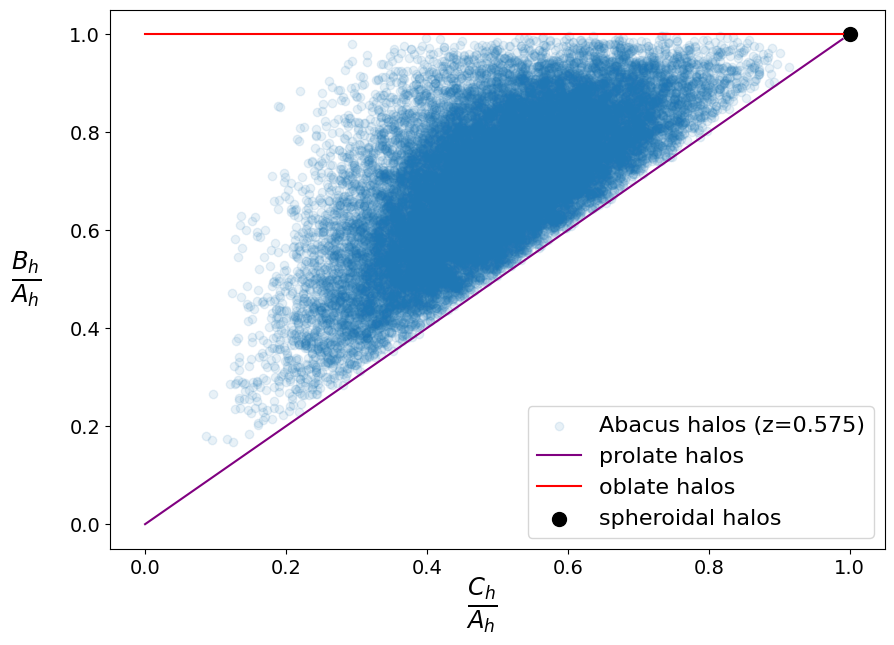

In [66]:
eigenvalues = halos_table['sigman_L2com'][:25_000]

A_h, B_h, C_h = eigenvalues[:,0]**2,eigenvalues[:,1]**2,eigenvalues[:,2]**2


plt.figure( figsize = (10,7) )
plt.scatter(C_h/A_h, B_h/A_h,alpha=0.1,label="Abacus halos (z=0.575)")

plt.xlabel(r"$\frac{C_h}{A_h}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')
plt.ylabel(r"$\frac{B_h}{A_h}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')

x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='purple',label='prolate halos')
plt.plot(x, np.ones(len(x)),color='red',label='oblate halos')
plt.scatter([1], [1], color='black', label='spheroidal halos', s=100)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('3D_halo_shapes.pdf', bbox_inches='tight')

### Some functions required for further work...

- ...to compute projected ellipticities

In [3]:
# Some functions required for further work

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

- ...to format ellipsoidal halos to match Abacus

In [4]:
def format_ellipsoid(eigenvectors, eigenvalues, position = np.asarray([0,0,0])):

    el = Table()
    el['sigman_eigenvecsMin_L2com'] = eigenvectors[0]
    el['sigman_eigenvecsMid_L2com'] = eigenvectors[1]
    el['sigman_eigenvecsMaj_L2com'] = eigenvectors[2]
    
    el['sigman_L2com'] = np.sqrt(eigenvalues)
    el['sigma_L2com'] = position
    
    return el

### Model : 3D galaxies populating halos (galaxy-halo connection)

- Parameters : $\theta = \{\mu_{\tau_B}, \mu_{\tau_C}, \sigma_{\tau_B}, \sigma_{\tau_C}, r_\tau\}$

- Gaussian draw : $f(\mathbf{x}) = \frac{1}{2\pi \, |\boldsymbol{\Sigma}|^{1/2}} \, \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)$

with :
- Mean vector : $x = \begin{bmatrix}
\mu_{\tau_B} \\
\mu_{\tau_C}
\end{bmatrix}
$

- Covariance matrix : $
\Sigma =
\begin{bmatrix}
\sigma_{\tau_B}^{2} & r_{\tau}\,\sigma_{\tau_B}\sigma_{\tau_C} \\
r_{\tau}\,\sigma_{\tau_B}\sigma_{\tau_C} & \sigma_{\tau_C}^{2}
\end{bmatrix}
$

In [5]:
def population_3D(mu_tau_B, mu_tau_C,
                sigma_tau_B, sigma_tau_C,
                r_tau,
                el=halos_table,
                nb_halos=nb_halos,
                batch_size=5000,
                max_iter=1000):

    halos_table2 = el.copy()
    axis_orig = np.array(halos_table2['sigman_L2com']**2)

    valid_axes = np.zeros_like(axis_orig)
    found_mask = np.zeros(nb_halos, dtype=bool)


    n_iter = 0
    while not np.all(found_mask) and n_iter < max_iter:
        n_iter += 1

        remaining = np.sum(~found_mask)
        if remaining == 0:
            break


        taus = np.random.multivariate_normal(
            mean=[mu_tau_B, mu_tau_C],
            cov=[
                [sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],
                [r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2],
            ],
            size=min(batch_size, remaining)
        )

        tau_B2 = np.clip(taus[:, 0], 0, 1)
        tau_C2 = np.clip(taus[:, 1], 0, 1)


        idx_remaining = np.where(~found_mask)[0][:len(tau_B2)]
        A = axis_orig[idx_remaining, 0]
        B = axis_orig[idx_remaining, 1] * tau_B2
        C = axis_orig[idx_remaining, 2] * tau_C2


        mask = (B / A <= 1) & (C / A <= 1) & (B >= C) & (B > 0) & (C > 0)

        valid_idx = idx_remaining[mask]
        valid_axes[valid_idx, 0] = A[mask]
        valid_axes[valid_idx, 1] = B[mask]
        valid_axes[valid_idx, 2] = C[mask]

        found_mask[valid_idx] = True


    if not np.all(found_mask):
        missing = np.where(~found_mask)[0]
        valid_axes[missing] = axis_orig[missing]


    eigenvecs_Min = halos_table2['sigman_eigenvecsMin_L2com']
    eigenvecs_Mid = halos_table2['sigman_eigenvecsMid_L2com']
    eigenvecs_Max = halos_table2['sigman_eigenvecsMaj_L2com']
    eigenvectors = np.stack((eigenvecs_Min, eigenvecs_Mid, eigenvecs_Max), axis=1)


    ellipsoids = np.array([
        format_ellipsoid(eigenvectors[i, :, :], valid_axes[i, :])
        for i in range(nb_halos)
    ])

    evcl = np.array([
        ellipsoids['sigman_eigenvecsMaj_L2com'],
        ellipsoids['sigman_eigenvecsMid_L2com'],
        ellipsoids['sigman_eigenvecsMin_L2com']
    ])
    evcl = np.transpose(evcl, (1, 0, 2))
    axis_lengths = ellipsoids['sigman_L2com']**2

    return evcl, axis_lengths

### Projection of the 3D population in 2D


In [6]:
# Function to project the 3D ellipsoidal galaxies of the modeled population in 2D along and perpendicular to the line-of-sight (LOS)
# returns the projected ellipticity of the galaxies

def projection (evcl, evls, p_axis='', e_bins=np.linspace(0,1,100)) :

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p)

    e = [e1,e2] ; e=np.array(e)


    # Final output = summary statistics = P(e)
    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)

    return e_counts

### Misalignment

### Simulator that performs forward simulations : from the input model parameters $\theta$ to the output summary statistics $P(\lvert e \rvert)$

In [7]:
# SIMULATOR (for simulation-based inference): projection of the 3D galaxies-halos in 2D along the line of sight ('y')
# Output = summary statistics = P(e)

# References : 
    # (1) Lamman et al., https://arxiv.org/pdf/2209.03949
    # (2) From Gendzwill D. J., Stauffer M. R., 1981, https://www.researchgate.net/profile/D-Gendzwill/publication/225869829_Analysis_of_triaxial_ellipsoids_Their_shapes_plane_sections_and_plane_projections/links/5aa18aa2a6fdcc22e2d11fc5/Analysis-of-triaxial-ellipsoids-Their-shapes-plane-sections-and-plane-projections.pdf

def simulator(theta, 
                el=halos_table,
                nb_halos=nb_halos, 
                p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
               ):

    mu_tau_B, mu_tau_C, sigma_tau_B, sigma_tau_C, r_tau = theta

    evcl, evls = population_3D (mu_tau_B, mu_tau_C, sigma_tau_B, sigma_tau_C, r_tau, el, nb_halos)

    e_counts = projection (evcl, evls, p_axis=p_axis)

    return torch.tensor(e_counts / float(nb_halos), dtype=torch.float32)

### Downloading the data for analysis

- Samples of galaxies considered : ELG, LRG, BGS (DESI data) and CMASS galaxies (SDSS data), matched with UNIONS shapes

In [8]:
# CMASS-UNIONS

unions_cmass_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/UNIONS-SDSS/unions1.5.3_cmass_cross.fits')

names = [name for name in unions_cmass_table.colnames if len(unions_cmass_table[name].shape) <= 1]
filtered_tbl = unions_cmass_table[names]

unions_cmass_cross = filtered_tbl.to_pandas()
unions_cmass_cross.columns

nb_unions_cmass = len(unions_cmass_cross) ; print(f"Number of CMASS-UNIONS galaxies (BOSS) : {nb_unions_cmass}")

unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)


e1_values = unions_cmass_cross['e1'][unions_cmass_index]
e2_values = unions_cmass_cross['e2'][unions_cmass_index]


e_cmass = np.vectorize(abs_e)(e1_values, e2_values)


e_bins=np.linspace(0, 1, 100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_cmass_counts,_ = np.histogram(e_cmass, bins = e_bins)

Number of CMASS-UNIONS galaxies (BOSS) : 210440


In [9]:
# ELG-UNIONS

unions_elg_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/UNIONS-DESI/unions1.5.3_elg_cross.fits')

names = [name for name in unions_elg_table.colnames if len(unions_elg_table[name].shape) <= 1]
filtered_tbl = unions_elg_table[names]

unions_elg_cross = filtered_tbl.to_pandas()
unions_elg_cross.columns

nb_unions_elg = len(unions_elg_cross) ; print(f"Number of ELG-UNIONS : {nb_unions_elg}")

unions_elg_index = unions_elg_cross.index
unions_elg_index=np.array(unions_elg_index)


e1_values = unions_elg_cross['e1'][unions_elg_index]
e2_values = unions_elg_cross['e2'][unions_elg_index]


e_elg = np.vectorize(abs_e)(e1_values, e2_values)


e_bins=np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_elg_counts,_ = np.histogram(e_elg, bins = e_bins) 

Number of ELG-UNIONS : 265926


In [10]:
# LRG-UNIONS

unions_lrg_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/UNIONS-DESI/unions1.5.3_lrg_cross.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg_cross = filtered_tbl.to_pandas()
unions_lrg_cross.columns

nb_unions_lrg = len(unions_lrg_cross) ; print(f"Number of LRG-UNIONS : {nb_unions_lrg}")

unions_lrg_index = unions_lrg_cross.index


e1_values = unions_lrg_cross['e1'][unions_lrg_index]
e2_values = unions_lrg_cross['e2'][unions_lrg_index]


e_lrg = np.vectorize(abs_e)(e1_values, e2_values)


e_bins=np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_lrg_counts,_ = np.histogram(e_lrg, bins = e_bins) 

Number of LRG-UNIONS : 329960


In [11]:
# DATA BGS

unions_bgs_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/UNIONS-DESI/unions1.5.3_bgs_cross.fits')

names = [name for name in unions_bgs_table.colnames if len(unions_bgs_table[name].shape) <= 1]
filtered_tbl = unions_bgs_table[names]

unions_bgs_cross = filtered_tbl.to_pandas()
unions_bgs_cross.columns


nb_unions_bgs = len(unions_bgs_cross) ; print(f"Number of BGS-UNIONS : {nb_unions_bgs}")

unions_bgs_index = unions_bgs_cross.index


e1_values = unions_bgs_cross['e1'][unions_bgs_index]
e2_values = unions_bgs_cross['e2'][unions_bgs_index]

e_bgs = np.vectorize(abs_e)(e1_values, e2_values)


e_bins=np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_bgs_counts,_ = np.histogram(e_bgs, bins = e_bins) 

Number of BGS-UNIONS : 1014631


### Downloading the posterior estimated by the neural network

In [12]:
class CustomPrior:
    pass

posterior = torch.load("posterior_abacus.pt",  weights_only=False)

###  Let group the observed summary statistics $P(\lvert e \rvert)$ in single vectors for each galaxy sample

In [13]:
e_bins=np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.


e_data_counts_cmass,_ = np.histogram(e_cmass, bins = e_bins) 
e_counts_data = [e_data_counts_cmass]
e_counts_data_cmass=np.array(e_counts_data)
x_obs_cmass = e_counts_data_cmass/nb_unions_cmass


e_data_counts_lrg,_ = np.histogram(e_lrg, bins = e_bins) 
e_counts_data = [e_data_counts_lrg]
e_counts_data_lrg=np.array(e_counts_data)
x_obs_lrg = e_counts_data_lrg/nb_unions_lrg


e_data_counts_elg,_ = np.histogram(e_elg, bins = e_bins) 
e_counts_data = [e_data_counts_elg]
e_counts_data_elg=np.array(e_counts_data)
x_obs_elg = e_counts_data_elg/nb_unions_elg


e_data_counts_bgs,_ = np.histogram(e_bgs, bins = e_bins) 
e_counts_data = [e_data_counts_bgs]
e_counts_data_bgs=np.array(e_counts_data)
x_obs_bgs = e_counts_data_bgs/nb_unions_bgs

### Sampling the posterior for the different data vectors

In [14]:
nb_samples = 1000

samples = posterior.sample((nb_samples,), x=x_obs_cmass)
samples_cmass = samples.numpy()

samples = posterior.sample((nb_samples,), x=x_obs_lrg)
samples_lrg = samples.numpy()

samples = posterior.sample((nb_samples,), x=x_obs_elg)
samples_elg = samples.numpy()

samples = posterior.sample((nb_samples,), x=x_obs_bgs)
samples_bgs = samples.numpy()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

### Inference results: constraints on the parameters $\theta$, plot of the corresponding marginalised contours

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/1869351725.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


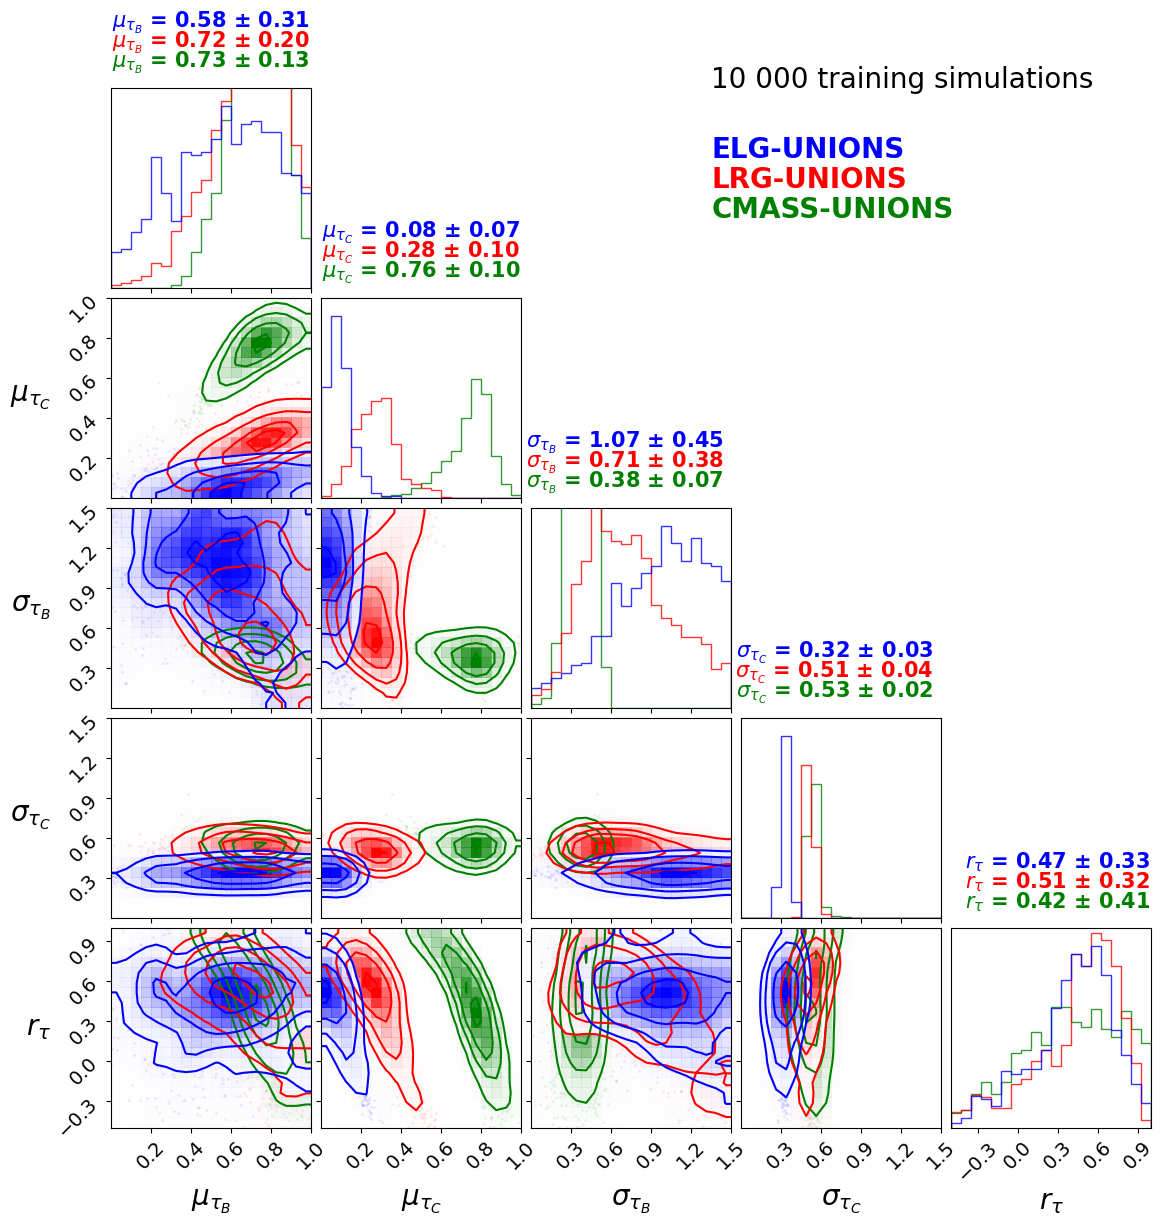

In [15]:
labels = [r"$\mu_{\tau_B}$", r"$\mu_{\tau_C}$", 
          r"$\sigma_{\tau_B}$", r"$\sigma_{\tau_C}$",
          r"$r_\tau$"]

ranges = [[0,1], [0, 1], [0, 1.5], [0, 1.5], [-0.5, 1]]


colors = ["green", "red", "blue"]
          #"orange"] 

dataset_labels = ["CMASS-UNIONS", "LRG-UNONS", "ELG-UNIONS"]
                  #"BGS-UNIONS"]

samples_list = [samples_cmass, samples_lrg, samples_elg]
                #samples_bgs]
            


fig = corner.corner(
    samples_cmass, 
    labels=labels, 
    range=ranges,
    show_titles=False,  # On évite de réécrire les titres à chaque fois
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[0], 
    hist_kwargs={"density": True, "alpha": 0.8},
)


corner.corner(
    samples_lrg, 
    labels=labels, 
    range=ranges, 
    show_titles=False, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  # Lissage des contours pour un rendu plus propre
    plot_density=True,  # Ajout des contours
    plot_contours=True,  # Tracer les contours de densité
    color=colors[1],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  # Utilisation de la figure existante
)


corner.corner(
    samples_elg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  # On évite de réécrire les titres à chaque fois
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[2], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  # Utilisation de la figure existante
)

# corner.corner(
#     samples_bgs, 
#     labels=labels, 
#     range=ranges, 
#     show_titles=False,  
#     title_kwargs={"fontsize": 16},
#     label_kwargs={"fontsize": 16}, 
#     smooth=1.2,  
#     plot_density=True,  
#     plot_contours=True,  
#     color=colors[3], 
#     hist_kwargs={"density": True, "alpha": 0.8},
#     fig=plt.gcf()
# )



ax = fig.axes[0]  # Prendre le premier axe pour placer les annotations
ax.annotate("10 000 training simulations", xy=(3, 1), xycoords="axes fraction", color='black', fontsize=20)
ax.annotate("CMASS-UNIONS", xy=(3, 0.35), xycoords="axes fraction", color=colors[0], fontsize=20, fontweight="bold")
ax.annotate("ELG-UNIONS", xy=(3, 0.65), xycoords="axes fraction", color=colors[2], fontsize=20, fontweight="bold")
ax.annotate("LRG-UNIONS", xy=(3, 0.5), xycoords="axes fraction", color=colors[1], fontsize=20, fontweight="bold")
#ax.annotate("BGS-UNIONS", xy=(3, 0.80), xycoords="axes fraction", color=colors[3], fontsize=20, fontweight="bold")


#Ajouter les valeurs moyennes et erreurs colorées au-dessus des histogrammes
axes = np.array(fig.axes).reshape((len(labels), len(labels)))


for i in range(len(labels)):
    ax = axes[i, i]
    y_max = ax.get_ylim()[1]
    y_offset = 0.1 * y_max

    for dataset, color, dataset_name in zip(samples_list, colors, dataset_labels):
        median = np.median(dataset[:, i])
        q16, q84 = np.percentile(dataset[:, i], [16, 84])
        err_minus, err_plus = median - q16, q84 - median

        # Adjust x position for specific labels
        x_pos = 0.05  # Default x position
        if labels[i] == r"$\mu_{\tau_B}$":
            x_pos = 0.5  # Center for r
        elif labels[i] == r"$\mu_{\tau_C}$":
            x_pos = 0.5  # Center for r
        elif labels[i] == r"$\sigma_{\tau_B}$":
            x_pos = 0.7  # Center for sigma_C
        elif labels[i] == r"$\sigma_{\tau_C}$":
            x_pos = 0.7  # Center for sigma_C
        elif labels[i] == r"$r_\tau$":
            x_pos = 0.3  # Center for r

        ax.text(
            x_pos, y_max + y_offset, 
            f"{labels[i]} = {median:.2f} ± {(err_plus + err_minus) / 2:.2f}",
            color=color, fontsize=15, fontweight="bold",
            ha="center", transform=ax.transData
        )
        y_offset += 0.1 * y_max


for ax in fig.axes:
    ax.tick_params(labelsize=14)


# Faire pivoter les labels à gauche de 90°
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(1, len(labels)):  # de la 2e ligne à la dernière
    ax = axes[i, 0]  # première colonne
    label = ax.get_ylabel()
    ax.set_ylabel(label, rotation=0, fontsize=20, ha='right', va='center')

# Mettre les labels du bas à fontsize=25
for i in range(len(labels)):
    ax = axes[-1, i]  # dernière ligne
    label = ax.get_xlabel()
    ax.set_xlabel(label, fontsize=20)

fig.show()

plt.savefig('3D_constraints_all_Abacus.pdf', bbox_inches='tight')

### Validation tests

#### Ensemble test

In [22]:
class CustomPrior:
    pass

posterior1 = torch.load("posterior_abacus1.pt",  weights_only=False)
posterior2 = torch.load("posterior_abacus2.pt",  weights_only=False)
posterior3 = torch.load("posterior_abacus3.pt",  weights_only=False)


nb_samples = 1000

samples1 = posterior1.sample((nb_samples,), x=x_obs_cmass)
samples1 = samples1.numpy()

samples2 = posterior2.sample((nb_samples,), x=x_obs_cmass)
samples2 = samples2.numpy()

samples3 = posterior3.sample((nb_samples,), x=x_obs_cmass)
samples3 = samples3.numpy()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/212168842.py:130: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


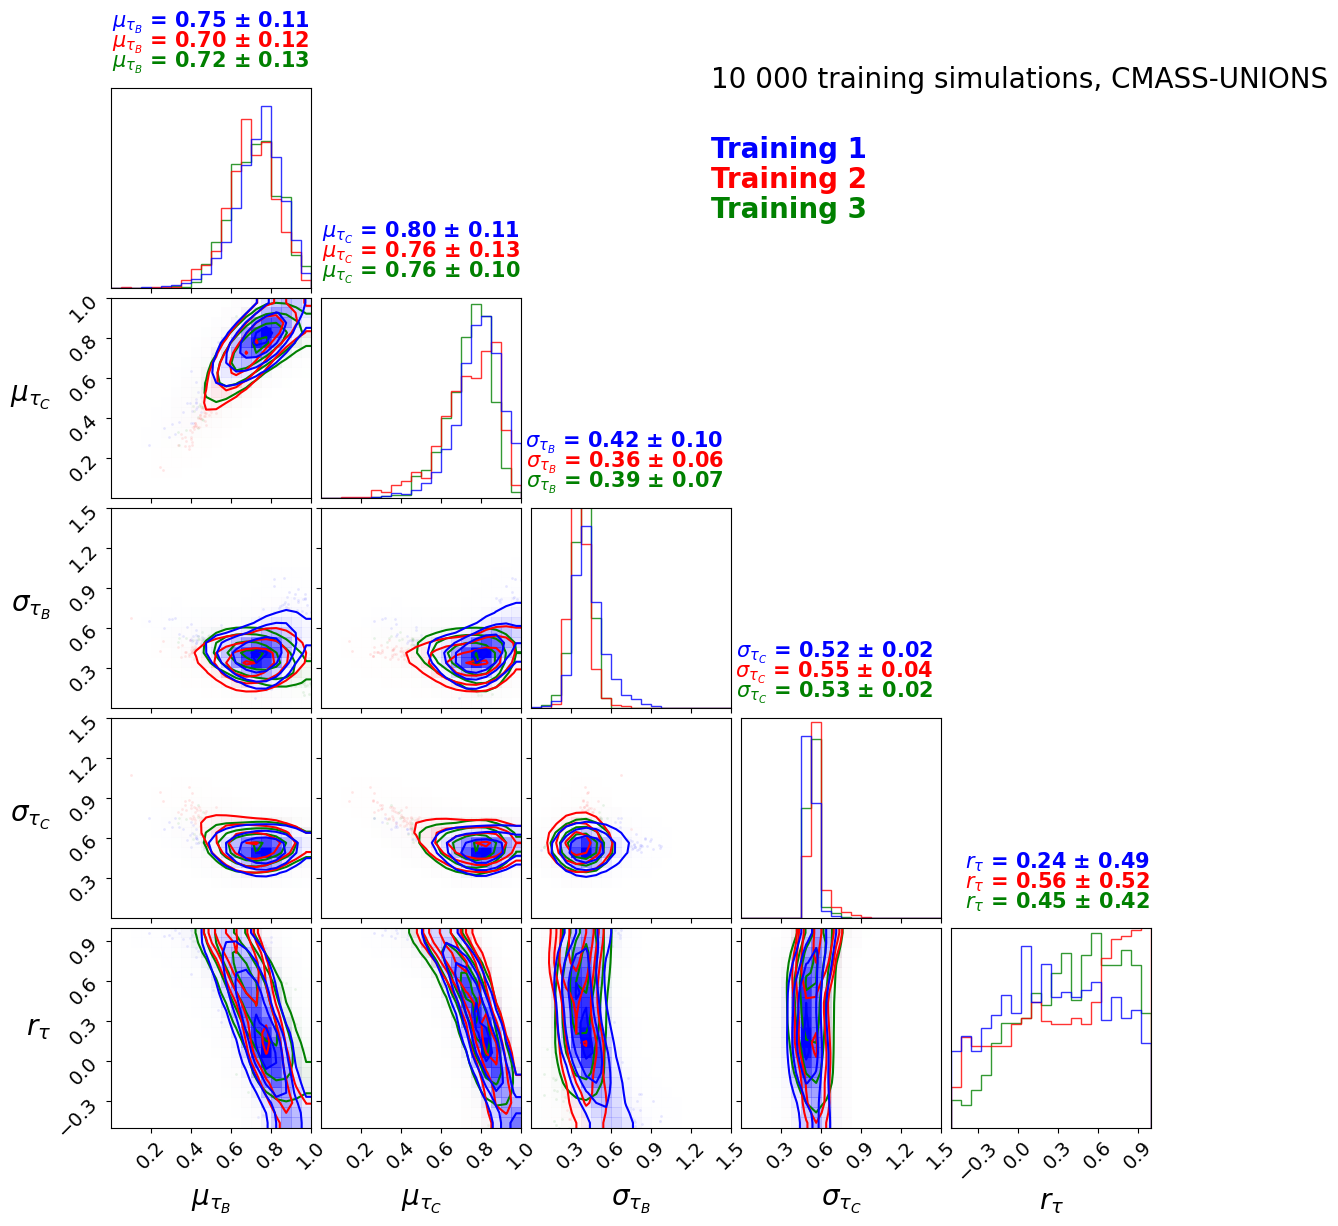

In [30]:
labels = [r"$\mu_{\tau_B}$", r"$\mu_{\tau_C}$", 
          r"$\sigma_{\tau_B}$", r"$\sigma_{\tau_C}$",
          r"$r_\tau$"]

ranges = [[0,1], [0, 1],  [0, 1.5], [0, 1.5], [-0.5, 1]]


colors = ["green", "red", "blue"] 

dataset_labels = ["training 1", "training 2" , "training 3"]

samples_list = [samples1, samples2, samples3]
                


fig = corner.corner(
    samples1, 
    labels=labels, 
    range=ranges,
    show_titles=False,  # On évite de réécrire les titres à chaque fois
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[0], 
    hist_kwargs={"density": True, "alpha": 0.8},
)


corner.corner(
    samples2, 
    labels=labels, 
    range=ranges, 
    show_titles=False, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  # Lissage des contours pour un rendu plus propre
    plot_density=True,  # Ajout des contours
    plot_contours=True,  # Tracer les contours de densité
    color=colors[1],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  # Utilisation de la figure existante
)


corner.corner(
    samples3, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  # On évite de réécrire les titres à chaque fois
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[2], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  # Utilisation de la figure existante
)





ax = fig.axes[0]  # Prendre le premier axe pour placer les annotations
ax.annotate("10 000 training simulations, CMASS-UNIONS", xy=(3, 1), xycoords="axes fraction", color='black', fontsize=20)
ax.annotate("Training 1", xy=(3, 0.65), xycoords="axes fraction", color=colors[2], fontsize=20, fontweight="bold")
ax.annotate("Training 2", xy=(3, 0.5), xycoords="axes fraction", color=colors[1], fontsize=20, fontweight="bold")
ax.annotate("Training 3", xy=(3, 0.35), xycoords="axes fraction", color=colors[0], fontsize=20, fontweight="bold")


#Ajouter les valeurs moyennes et erreurs colorées au-dessus des histogrammes
axes = np.array(fig.axes).reshape((len(labels), len(labels)))


for i in range(len(labels)):
    ax = axes[i, i]
    y_max = ax.get_ylim()[1]
    y_offset = 0.1 * y_max

    for dataset, color, dataset_name in zip(samples_list, colors, dataset_labels):
        median = np.median(dataset[:, i])
        q16, q84 = np.percentile(dataset[:, i], [16, 84])
        err_minus, err_plus = median - q16, q84 - median

        # Adjust x position for specific labels
        x_pos = 0.05  # Default x position
        if labels[i] == r"$\mu_{\tau_B}$":
            x_pos = 0.5  # Center for r
        elif labels[i] == r"$\mu_{\tau_C}$":
            x_pos = 0.5  # Center for r
        elif labels[i] == r"$\sigma_{\tau_A}$":
            x_pos = 0.7  # Center for sigma_C
        elif labels[i] == r"$\sigma_{\tau_B}$":
            x_pos = 0.7  # Center for sigma_C
        elif labels[i] == r"$\sigma_{\tau_C}$":
            x_pos = 0.7  # Center for sigma_C
        elif labels[i] == r"$r_\tau$":
            x_pos = 0.3  # Center for r_\tau
 
        

        ax.text(
            x_pos, y_max + y_offset, 
            f"{labels[i]} = {median:.2f} ± {(err_plus + err_minus) / 2:.2f}",
            color=color, fontsize=15, fontweight="bold",
            ha="center", transform=ax.transData
        )
        y_offset += 0.1 * y_max


for ax in fig.axes:
    ax.tick_params(labelsize=14)


# Faire pivoter les labels à gauche de 90°
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(1, len(labels)):  # de la 2e ligne à la dernière
    ax = axes[i, 0]  # première colonne
    label = ax.get_ylabel()
    ax.set_ylabel(label, rotation=0, fontsize=20, ha='right', va='center')

# Mettre les labels du bas à fontsize=25
for i in range(len(labels)):
    ax = axes[-1, i]  # dernière ligne
    label = ax.get_xlabel()
    ax.set_xlabel(label, fontsize=20)

fig.show()

plt.savefig('Ensemble_test.pdf', bbox_inches='tight')

#### Posterior predictive checks

In [96]:
e_counts_simulated_cmass = np.apply_along_axis(simulator, 1, samples_cmass)
hdu = fits.PrimaryHDU(e_counts_simulated_cmass) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_cmass.fits', overwrite=True)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_93077/3856932293.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  taus = np.random.multivariate_normal(
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_93077/1626993374.py:26: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))


In [16]:
hdul = fits.open('e_counts_simulated_cmass.fits') 
e_counts_simulated_cmass = hdul[0].data

median_cmass = np.median(e_counts_simulated_cmass, axis=0)
quantiles_cmass = np.quantile(e_counts_simulated_cmass, [0.16,0.84], axis=0)

In [17]:
e_counts_simulated_elg = np.apply_along_axis(simulator, 1, samples_elg)
hdu = fits.PrimaryHDU(e_counts_simulated_elg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_elg.fits', overwrite=True)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/3856932293.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  taus = np.random.multivariate_normal(
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/1626993374.py:26: RuntimeWarning: divide by zero encountered in divide
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/1626993374.py:26: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))


In [18]:
hdul = fits.open('e_counts_simulated_elg.fits') 
e_counts_simulated_elg = hdul[0].data

median_elg = np.median(e_counts_simulated_elg, axis=0)
quantiles_elg = np.quantile(e_counts_simulated_elg, [0.16,0.84], axis=0)

In [19]:
e_counts_simulated_lrg = np.apply_along_axis(simulator, 1, samples_lrg)
hdu = fits.PrimaryHDU(e_counts_simulated_lrg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_lrg.fits', overwrite=True)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/1626993374.py:26: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_9625/3856932293.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  taus = np.random.multivariate_normal(


In [20]:
hdul = fits.open('e_counts_simulated_lrg.fits') 
e_counts_simulated_lrg = hdul[0].data
median_lrg = np.median(e_counts_simulated_lrg, axis=0)
quantiles_lrg = np.quantile(e_counts_simulated_lrg, [0.16,0.84], axis=0)

In [ ]:
e_counts_simulated_bgs = np.apply_along_axis(simulator, 1, samples_bgs)
hdu = fits.PrimaryHDU(e_counts_simulated_bgs) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_bgs.fits', overwrite=True)

In [33]:
hdul = fits.open('e_counts_simulated_bgs.fits') 
e_counts_simulated_bgs = hdul[0].data
median_bgs = np.median(e_counts_simulated_bgs, axis=0)
quantiles_bgs = np.quantile(e_counts_simulated_bgs, [0.16,0.84], axis=0)

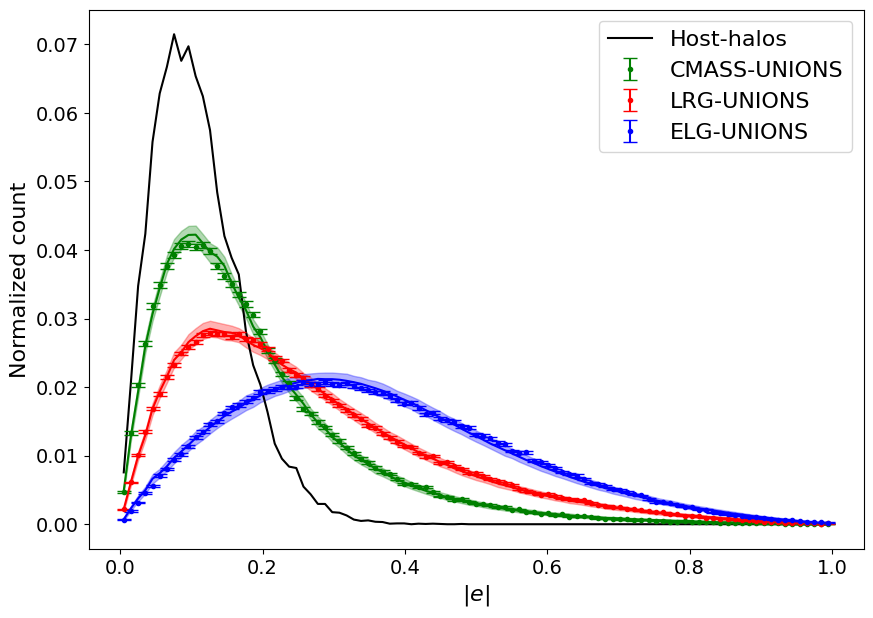

In [23]:
e_bins=np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.


plt.figure(figsize = (10,7) )

e_h = simulator([1,1,0,0,0], el=halos_table)


plt.plot(e_cents,e_h, label=r"Host-halos", color='black')


plt.plot(e_cents,median_cmass, linestyle='-',color='green')
plt.errorbar(e_cents, e_data_counts_cmass/nb_unions_cmass, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, fmt='o',markersize=3, capsize=5, label='CMASS-UNIONS', color='green')
plt.fill_between(e_cents, quantiles_cmass[0,:], quantiles_cmass[1,:], color='green', alpha=0.3)

plt.plot(e_cents,median_lrg, linestyle='-',color='red')
plt.errorbar(e_cents, e_data_counts_lrg/nb_unions_lrg, yerr=np.sqrt(e_data_counts_lrg) / nb_unions_lrg, fmt='o',markersize=3, capsize=5, label='LRG-UNIONS', color='red')
plt.fill_between(e_cents, quantiles_lrg[0,:], quantiles_lrg[1,:], color='red', alpha=0.3)

plt.plot(e_cents,median_elg, linestyle='-',color='blue')
plt.errorbar(e_cents, e_data_counts_elg/nb_unions_elg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, fmt='o',markersize=3, capsize=5, label='ELG-UNIONS', color='blue')
plt.fill_between(e_cents, quantiles_elg[0,:], quantiles_elg[1,:], color='blue', alpha=0.3)

# plt.plot(e_cents,median_bgs, linestyle='-',color='orange')
# plt.errorbar(e_cents, e_data_counts_bgs/nb_unions_bgs, yerr=np.sqrt(e_data_counts_bgs) / nb_unions_bgs, fmt='o',markersize=3, capsize=5, label='BGS-UNIONS', color='orange')
# plt.fill_between(e_cents, quantiles_bgs[0,:], quantiles_bgs[1,:], color='orange', alpha=0.3)




plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("P(e)_all_abacus.pdf", bbox_inches='tight')

#### Recovering best fit parameters

In [39]:
theta_estimated=np.median(samples_cmass, axis=0)
tau_B_cmass, tau_C_cmass, sigma_tau_B_cmass, sigma_tau_C_cmass, r_tau_cmass = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
print(f"Best fit CMASS-UNIONS {tau_B_cmass, tau_C_cmass, sigma_tau_B_cmass, sigma_tau_C_cmass, r_tau_cmass}")

theta_estimated=np.median(samples_lrg, axis=0)
tau_B_lrg, tau_C_lrg, sigma_tau_B_lrg, sigma_tau_C_lrg, r_tau_lrg = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
print(f"Best fit LRG-UNIONS {tau_B_lrg, tau_C_lrg, sigma_tau_B_lrg, sigma_tau_C_lrg,  r_tau_lrg}")

theta_estimated=np.median(samples_elg, axis=0)
tau_B_elg, tau_C_elg, sigma_tau_B_elg, sigma_tau_C_elg, r_tau_elg = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
print(f"Best fit ELG-UNIONS { tau_B_elg, tau_C_elg, sigma_tau_B_elg, sigma_tau_C_elg, r_tau_elg}")

# theta_estimated=np.median(samples_bgs, axis=0)
# tau_B_bgs, tau_C_bgs, sigma_tau_B_bgs, sigma_tau_C_bgs, r_tau_bgs = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
# print(f"Best fit BGS-UNIONS { tau_B_bgs, tau_C_bgs, sigma_tau_B_bgs, sigma_tau_C_bgs, r_tau_bgs}")

Best fit CMASS-UNIONS (0.7343442, 0.7643886, 0.38468415, 0.53263533, 0.424736)
Best fit LRG-UNIONS (0.71632314, 0.27798772, 0.7114612, 0.50819147, 0.51334965)
Best fit ELG-UNIONS (0.5829569, 0.08139161, 1.0661209, 0.32429084, 0.46544963)


In [36]:
cmass = halos_table.copy()

cmass2 = np.array(cmass['sigman_L2com']**2)

taus = np.random.multivariate_normal(mean=[tau_B_cmass, tau_C_cmass], 
                                    cov=[[sigma_tau_B_cmass**2, r_tau_cmass * sigma_tau_B_cmass * sigma_tau_C_cmass],
                                    [r_tau_cmass * sigma_tau_B_cmass * sigma_tau_C_cmass, sigma_tau_C_cmass**2]],
                                    size=nb_halos)
    
tau_B2 = np.clip(taus[:, 0], 0, 1)
tau_C2 = np.clip(taus[:, 1], 0, 1)

cmass2[:,0] = cmass2[:,0] ; cmass2[:,1] = cmass2[:,1]*tau_B2 ; cmass2[:,2] = cmass2[:,2]*tau_C2

cmass['sigman_L2com'] = cmass2






lrg = halos_table.copy()

lrg2 = np.array(lrg['sigman_L2com']**2)

taus = np.random.multivariate_normal(mean=[tau_B_lrg, tau_C_lrg], 
                                    cov=[[sigma_tau_B_lrg**2, r_tau_lrg * sigma_tau_B_lrg * sigma_tau_C_lrg],
                                    [r_tau_lrg * sigma_tau_B_lrg * sigma_tau_C_lrg, sigma_tau_C_lrg**2]],
                                    size=nb_halos)
    
tau_B2 = np.clip(taus[:, 0], 0, 1)
tau_C2 = np.clip(taus[:, 1], 0, 1)

lrg2[:,0] = lrg2[:,0] ; lrg2[:,1] = lrg2[:,1]*tau_B2 ; lrg2[:,2] = lrg2[:,2]*tau_C2

lrg['sigman_L2com'] = lrg2





elg = halos_table.copy()

elg2 = np.array(lrg['sigman_L2com']**2)

taus = np.random.multivariate_normal(mean=[tau_B_elg, tau_C_elg], 
                                    cov=[[sigma_tau_B_elg**2, r_tau_elg * sigma_tau_B_elg * sigma_tau_C_elg],
                                    [r_tau_elg * sigma_tau_B_elg * sigma_tau_C_elg, sigma_tau_C_elg**2]],
                                    size=nb_halos)
    

tau_B2 = np.clip(taus[:, 0], 0, 1)
tau_C2 = np.clip(taus[:, 1], 0, 1)

elg2[:,0] = elg2[:,0] ; elg2[:,1] = elg2[:,1]*tau_B2 ; elg2[:,2] = elg2[:,2]*tau_C2

elg['sigman_L2com'] = elg2

/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


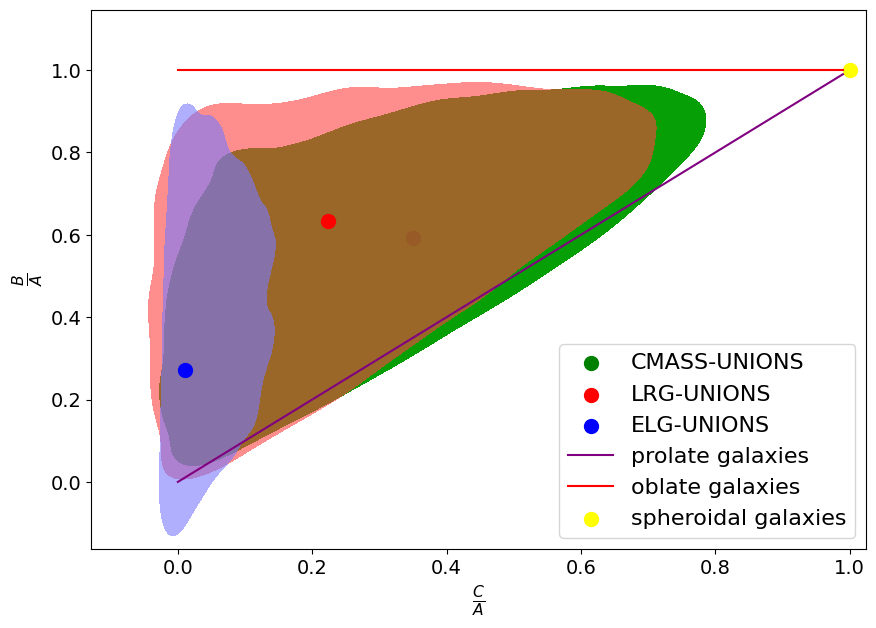

In [38]:
Ag, Bg, Cg = cmass2[:,0], cmass2[:,1], cmass2[:,2]
mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
ABC = cmass2[mask]
A_cmass, B_cmass, C_cmass = ABC[:5000,0], ABC[:5000,1], ABC[:5000,2]


Ag, Bg, Cg = lrg2[:,0], lrg2[:,1], lrg2[:,2]
mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
ABC = lrg2[mask]
A_lrg, B_lrg, C_lrg = ABC[:5000,0], ABC[:5000,1], ABC[:5000,2]


Ag, Bg, Cg = elg2[:,0], elg2[:,1], elg2[:,2]
mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
ABC = elg2[mask]
A_elg, B_elg, C_elg = ABC[:5000,0], ABC[:5000,1], ABC[:5000,2]


haloes=np.array(halos_table['sigman_L2com'])
Ah, Bh, Ch = haloes[:5000,0]**2, haloes[:5000,1]**2, haloes[:5000,2]**2



plt.figure( figsize = (10,7) )

sns.kdeplot(x=C_cmass/A_cmass, y=B_cmass/A_cmass, levels=2, color='green', fill=True, alpha=1,linewidths=0,label='CMASS-UNIONS')
plt.scatter([np.median(C_cmass)/np.median(A_cmass)], [np.median(B_cmass)/np.median(A_cmass)], color='green', s=100,  label='CMASS-UNIONS')

sns.kdeplot(x=C_lrg/A_lrg, y=B_lrg/A_lrg, levels=2, color='red', fill=True, alpha=0.6,linewidths=0,label='LRG-UNIONS')
plt.scatter([np.median(C_lrg)/np.median(A_lrg)], [np.median(B_lrg)/np.median(A_lrg)], color='red', s=100, label='LRG-UNIONS')

sns.kdeplot(x=C_elg/A_elg, y=B_elg/A_elg, levels=2, color='blue', fill=True, alpha=0.6,linewidths=0,label='ELG-UNIONS')
plt.scatter([np.median(C_elg)/np.median(A_elg)], [np.median(B_elg)/np.median(A_elg)], color='blue', s=100,  label='ELG-UNIONS')


plt.xlabel(r"$\frac{C}{A}$",fontsize=16) ; plt.ylabel(r"$\frac{B}{A}$",fontsize=16)


x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='purple',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([1], [1], color='yellow', label='spheroidal galaxies', s=100)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("3D_populations.pdf", bbox_inches='tight')